# Using PySpark to Create an Amazon Review Recommendation System 



This Jupyter Notebook contains code to create a recommendation system for Amazon user reviews on specific videos using PySpark.  It was created as a final project for the class INFO 607: Applied Database Technologies at Drexel University.  The data was downloaded from [here](https://jmcauley.ucsd.edu/data/amazon/).  

Additional documentation on this project can be found at the Github repository [here](https://github.com/zachcarlson/ProductRecommender).

## Configuration

We recommend running this notebook in Google Colab using a local runtime and your GPU.  Here are [links](https://stackoverflow.com/questions/51002045/how-to-make-jupyter-notebook-to-run-on-gpu) to setting up this configuration:
- [Local Runtime](https://research.google.com/colaboratory/local-runtimes.html)
- [Utilizing GPU](https://medium.com/deep-learning-turkey/google-colab-free-gpu-tutorial-e113627b9f5d)

Configure your input directory below:

In [1]:
# INPUT_DIRECTORY = "/content/drive/MyDrive/Grad School/INFO 607/ProductRecommender/data/" #for google mount
INPUT_DIRECTORY = "ProductRecommender/data/" #for jupyter notebook

### Google Colab Hosted Runtime

**NOTE**: Due to the limited resources available for Google Colab's Free Tier, this notebook might not run for you if you are running it in Google Drive using a Hosted Runtime.  We recommend using a Google Colab Local Runtime.  However, if you have Colab Pro/Pro+, this notebook *might* work and you can uncomment the cells below to continue with that particular configuration.

In [2]:
# from google.colab import drive
# drive.mount('/content/drive')

In [3]:
# !pip install pyspark

The cell below may take 1-2 minutes to execute:

In [4]:
# %%capture 
# #prevent large printout with %%capture

# #Download Java
# !apt-get install openjdk-8-jdk-headless -qq > /dev/null

# #Install Apache Spark 3.2.1 with Hadoop 3.2, get zipped folder
# !wget -q https://dlcdn.apache.org/spark/spark-3.2.1/spark-3.2.1-bin-hadoop3.2.tgz

# #Unzip folder
# !tar xvf spark-3.2.1-bin-hadoop3.2.tgz

# #Install findspark, pyspark 3.2.1
# !pip install -q findspark
# !pip install pyspark==3.2.1

# #Set variables
# import os
# os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
# os.environ["SPARK_HOME"] = "spark-3.2.1-bin-hadoop3.2"

### Google Colab Local Runtime

We recommend using a local Jupyter Notebook as it is much faster for a free user, however, it will require some additional configuration.  Follow this tutorial [here](https://changhsinlee.com/install-pyspark-windows-jupyter/).  

In [5]:
import findspark
findspark.init()

## Load Packages

In [6]:
import pandas as pd
from pyspark import SparkContext
from pyspark.ml.evaluation import RegressionEvaluator
from pyspark.ml.recommendation import ALS
from pyspark.ml.tuning import CrossValidator
from pyspark.ml.tuning import ParamGridBuilder
from pyspark.sql import SparkSession
import pyspark.sql.functions as F
from pyspark.sql.functions import monotonically_increasing_id

## Data Acquisition, Preprocessing

### Import Data

In [7]:
#create SparkSession and SparkContext objects
from pyspark import SparkContext
from pyspark.sql import SparkSession

spark = SparkSession.builder.getOrCreate()
sc = SparkContext.getOrCreate()

You can either import the data locally using appropriate file organization or from the URL directly.  To import from URL uncomment the appropriate cell below:

In [8]:
#Import data via file
file_path = INPUT_DIRECTORY + "ratings_Amazon_Instant_Video.csv"
ratings = spark.read.csv(file_path, header=False, inferSchema=True)
ratings.show(5)

+--------------+----------+---+----------+
|           _c0|       _c1|_c2|       _c3|
+--------------+----------+---+----------+
|A1EE2E3N7PW666|B000GFDAUG|5.0|1202256000|
| AGZ8SM1BGK3CK|B000GFDAUG|5.0|1198195200|
|A2VHZ21245KBT7|B000GIOPK2|4.0|1215388800|
| ACX8YW2D5EGP6|B000GIOPK2|4.0|1185840000|
| A9RNMO9MUSMTJ|B000GIOPK2|2.0|1281052800|
+--------------+----------+---+----------+
only showing top 5 rows



In [9]:
#import data via URL 

#uncomment cells below to run this method
##from pyspark import SparkFiles
##url = "http://snap.stanford.edu/data/amazon/productGraph/categoryFiles/ratings_Amazon_Instant_Video.csv"
##spark.sparkContext.addFile(url)
##ratings = spark.read.csv(SparkFiles.get('ratings_Amazon_Instant_Video.csv'), header=False, inferSchema= True)

In [10]:
ratings_count = ratings.count()
print(f"{ratings_count:,d} Rows in dataset")

583,933 Rows in dataset


### Pre-processing

#### **Rename columns**

In [11]:
ratings = ratings.withColumnRenamed("_c0", "reviewerID") \
                  .withColumnRenamed("_c1", "videoID") \
                  .withColumnRenamed("_c2", "rating") \
                  .withColumnRenamed("_c3", "timestamp")
ratings.show(5)

+--------------+----------+------+----------+
|    reviewerID|   videoID|rating| timestamp|
+--------------+----------+------+----------+
|A1EE2E3N7PW666|B000GFDAUG|   5.0|1202256000|
| AGZ8SM1BGK3CK|B000GFDAUG|   5.0|1198195200|
|A2VHZ21245KBT7|B000GIOPK2|   4.0|1215388800|
| ACX8YW2D5EGP6|B000GIOPK2|   4.0|1185840000|
| A9RNMO9MUSMTJ|B000GIOPK2|   2.0|1281052800|
+--------------+----------+------+----------+
only showing top 5 rows



In [12]:
rev_count = ratings\
          .select("reviewerID")\
          .distinct()\
          .count()

print(f"{rev_count:,d} Reviewers")

426,922 Reviewers


In [13]:
video_count = ratings\
          .select("videoID")\
          .distinct()\
          .count()

print(f"{video_count:,d} Videos")

23,965 Videos


#### **Check datatypes**

In [14]:
ratings.printSchema()

root
 |-- reviewerID: string (nullable = true)
 |-- videoID: string (nullable = true)
 |-- rating: double (nullable = true)
 |-- timestamp: integer (nullable = true)



We need `reviewerID` and `videoID` to be integers for the ALS algorithm.  We'll create separate tables for `reviewers` and `videos`.  At the end of the pre-processing section, we'll combine the tables.

In [15]:
from pyspark.sql.functions import monotonically_increasing_id

reviewers = ratings.select("reviewerID").distinct().coalesce(1)
reviewers.show(5)

+--------------+
|    reviewerID|
+--------------+
|A3FF40QHATHVK0|
|A2OYUAR8I1QT2O|
|A28DPR143MALN7|
|A1RNJ6Q36443HL|
| A2YJL1MX3J4OK|
+--------------+
only showing top 5 rows



In [16]:
reviewers = reviewers.withColumn("userID", monotonically_increasing_id()).persist()
reviewers.show(5)

+--------------+------+
|    reviewerID|userID|
+--------------+------+
|A3FF40QHATHVK0|     0|
|A2OYUAR8I1QT2O|     1|
|A28DPR143MALN7|     2|
|A1RNJ6Q36443HL|     3|
| A2YJL1MX3J4OK|     4|
+--------------+------+
only showing top 5 rows



In [17]:
videos = ratings.select("videoID").distinct().coalesce(1)
videos = videos.withColumn("video_ID", monotonically_increasing_id()).persist()
videos.show(5)

+----------+--------+
|   videoID|video_ID|
+----------+--------+
|B000OC3FZQ|       0|
|B000P41FAA|       1|
|B000RKQEQW|       2|
|B000TS73MG|       3|
|B000U5IH7I|       4|
+----------+--------+
only showing top 5 rows



#### Duplicate Ratings

In [18]:
ratings\
.groupby("reviewerID", "videoID")\
.count()\
.select(F.max("count"))\
.show()

+----------+
|max(count)|
+----------+
|         1|
+----------+



Each user has only one rating per product, thus filtering based on `timestamp` is not needed.  We will keep the timestamp for EDA purposes and to allow for future filtering if the dataset contains multiple ratings for a given user for  a given product.

### Join tables

In [19]:
#Join ratings table with new integer IDs for videos and reviewers
video_ratings = ratings.join(reviewers, on="reviewerID", how="left")
video_ratings = video_ratings.join(videos, on="videoID", how="left")

#select just integer IDs, rating and timestamp
video_ratings = video_ratings.select("userID", "video_ID", "rating", "timestamp")
video_ratings.show(5)

+------+--------+------+----------+
|userID|video_ID|rating| timestamp|
+------+--------+------+----------+
| 37123|   19744|   5.0|1335657600|
| 34132|    9656|   2.0|1281052800|
| 33769|   18813|   5.0|1390435200|
| 83756|    9448|   5.0|1363824000|
| 63197|    8851|   5.0|1383696000|
+------+--------+------+----------+
only showing top 5 rows



In [20]:
#rename columns for readability
video_ratings = video_ratings.withColumnRenamed("userID", "reviewerID")
video_ratings = video_ratings.withColumnRenamed("video_ID", "videoID")
video_ratings.show(5)

+----------+-------+------+----------+
|reviewerID|videoID|rating| timestamp|
+----------+-------+------+----------+
|     37123|  19744|   5.0|1335657600|
|     34132|   9656|   2.0|1281052800|
|     33769|  18813|   5.0|1390435200|
|     83756|   9448|   5.0|1363824000|
|     63197|   8851|   5.0|1383696000|
+----------+-------+------+----------+
only showing top 5 rows



## EDA

Describe the dataset:

In [21]:
video_ratings.select("rating").describe().show()

+-------+------------------+
|summary|            rating|
+-------+------------------+
|  count|            583933|
|   mean| 4.316185247280082|
| stddev|1.1637059130358245|
|    min|               1.0|
|    max|               5.0|
+-------+------------------+



The ratings range from 1-5, with the mean being 4.32

Find reviewers with the most ratings:

In [22]:
video_ratings\
        .select("reviewerID", "rating")\
        .groupby("reviewerID")\
        .count()\
        .sort("count", ascending = False)\
        .show(5)

+----------+-----+
|reviewerID|count|
+----------+-----+
|    314359|  277|
|    320548|  240|
|    384298|  212|
|    173088|  142|
|    115356|  125|
+----------+-----+
only showing top 5 rows



No missing data

In [23]:
video_ratings\
        .where(
                F.col("reviewerID").isNull() |\
                F.col("videoID").isNull() |\
                F.col("rating").isNull()
              )\
        .count()

0

Find videos with the most ratings:

In [24]:
video_ratings\
        .select("videoID", "rating")\
        .groupby("videoID")\
        .count()\
        .sort("count", ascending = False)\
        .show(5)

+-------+-----+
|videoID|count|
+-------+-----+
|    452|12633|
|  15400|10938|
|   3875|10226|
|  23936| 8676|
|  20401| 6927|
+-------+-----+
only showing top 5 rows



Count and average ratings for each video

### Top 5 Videos

In [25]:
avg_ratings = (video_ratings
                .select("videoID", "rating")                          # Select Columns
                .groupby("videoID")                                   # Group by videoID
                .agg(                           
                     F.count("rating").alias("Count"),                  # Count number of ratings
                     F.avg("rating").alias("Average")                   # Average ratings for each video
                     )
                .sort("Average", "Count", ascending = [False, False])   # Sort results by average and count
               )
avg_ratings.show(5)

+-------+-----+-------+
|videoID|Count|Average|
+-------+-----+-------+
|  13490|   41|    5.0|
|   9406|   22|    5.0|
|  19381|   20|    5.0|
|   4990|   19|    5.0|
|  13295|   18|    5.0|
+-------+-----+-------+
only showing top 5 rows



Show highly rated videos with the most ratings:

In [26]:
high_ratings = (video_ratings
                .select("videoID", "rating")                          # Select Columns
                .groupby("videoID")                                   # Group by videoID
                .agg(                           
                     F.count("rating").alias("Count"),                  # Count number of ratings
                     F.avg("rating").alias("Average")                   # Average ratings for each video
                     )
                .sort("Count",  ascending =  False)                   # Sort results by count
               )
high_ratings.where(F.col("Average")> 4.8).show(10)

+-------+-----+-----------------+
|videoID|Count|          Average|
+-------+-----+-----------------+
|  20401| 6927|4.857947163274145|
|   5132| 4501|4.808487002888247|
|   3168| 3286|4.804930006086427|
|    425| 1401|4.844396859386153|
|   1929| 1309|4.881588999236058|
|  11515| 1191|4.812762384550798|
|    398| 1132|4.845406360424028|
|   8026| 1067|4.878163074039363|
|  16837|  961|4.855359001040583|
|  21580|  818|4.815403422982885|
+-------+-----+-----------------+
only showing top 10 rows



### Low Rating Videos

In [27]:
# Filter videos by their average ratings
low_avg_rating = avg_ratings.filter(avg_ratings.Average < 2)
low_avg_rating.show(5)

# Count number of videos with low ratings
lar_count = low_avg_rating.count()

# Print statistics
print(f"Number of distinct videos: {video_count :,d}")
print(f"Number of videos with low average (less than 2): {lar_count :,d}")
print(f"% low ratings: {lar_count / video_count * 100 :,.2f}")


+-------+-----+------------------+
|videoID|Count|           Average|
+-------+-----+------------------+
|  15484|   49|1.9795918367346939|
|  10601|   27| 1.962962962962963|
|  14583|   18|1.9444444444444444|
|  15959|   15|1.9333333333333333|
|  20019|   15|1.9333333333333333|
+-------+-----+------------------+
only showing top 5 rows

Number of distinct videos: 23,965
Number of videos with low average (less than 2): 2,124
% low ratings: 8.86


The precentage of low rating (less than 2) videos is low (8.9%). 

### Time Plot

In [28]:
import pyspark.sql.functions as F
from pyspark.sql.types import TimestampType

video_ratings = video_ratings.withColumn("timestamp", F.from_unixtime("timestamp"))
video_ratings.show()

+----------+-------+------+-------------------+
|reviewerID|videoID|rating|          timestamp|
+----------+-------+------+-------------------+
|     37123|  19744|   5.0|2012-04-28 20:00:00|
|      3351|   8851|   5.0|2014-01-02 19:00:00|
|      4693|   9448|   4.0|2013-06-04 20:00:00|
|     29294|  13121|   5.0|2013-05-30 20:00:00|
|     25324|  18813|   5.0|2014-06-13 20:00:00|
|     22897|  13121|   5.0|2013-09-03 20:00:00|
|      2561|   9448|   5.0|2013-12-28 19:00:00|
|     39239|  18813|   5.0|2014-04-10 20:00:00|
|     40358|  18813|   4.0|2014-04-01 20:00:00|
|     26408|  19744|   4.0|2012-03-14 20:00:00|
|     34132|   9656|   2.0|2010-08-05 20:00:00|
|     33769|  18813|   5.0|2014-01-22 19:00:00|
|     43569|  19744|   5.0|2012-07-04 20:00:00|
|     23613|   9448|   5.0|2014-03-16 20:00:00|
|     32450|   9448|   5.0|2014-02-06 19:00:00|
|     30431|   8851|   5.0|2014-06-29 20:00:00|
|     70998|   9448|   5.0|2013-06-19 20:00:00|
|     62829|  19744|   5.0|2012-12-22 19

In [29]:
video_ratings.select(F.min("timestamp")).show()

+-------------------+
|     min(timestamp)|
+-------------------+
|1999-08-23 20:00:00|
+-------------------+



In [30]:
video_ratings.select(F.max("timestamp")).show()

+-------------------+
|     max(timestamp)|
+-------------------+
|2014-07-22 20:00:00|
+-------------------+



In [31]:
pandas_video_ratings = video_ratings.toPandas() #convert pyspark df to pandas df
pandas_video_ratings['timestamp'] = pd.to_datetime(pandas_video_ratings["timestamp"])
pandas_video_ratings["year"] = pandas_video_ratings["timestamp"].dt.year
pandas_video_ratings.head()

,reviewerID,videoID,rating,timestamp,year
0,31850,4685,4.0,2014-02-23 19:00:00,2014
1,20690,6119,5.0,2013-04-18 20:00:00,2013
2,31491,452,5.0,2014-04-28 20:00:00,2014
3,6720,20210,5.0,2014-02-09 19:00:00,2014
4,6720,4685,5.0,2014-02-09 19:00:00,2014


In [32]:
pandas_video_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 583933 entries, 0 to 583932
Data columns (total 5 columns):
 #   Column      Non-Null Count   Dtype         
---  ------      --------------   -----         
 0   reviewerID  583933 non-null  int64         
 1   videoID     583933 non-null  int64         
 2   rating      583933 non-null  float64       
 3   timestamp   583933 non-null  datetime64[ns]
 4   year        583933 non-null  int64         
dtypes: datetime64[ns](1), float64(1), int64(3)
memory usage: 22.3 MB


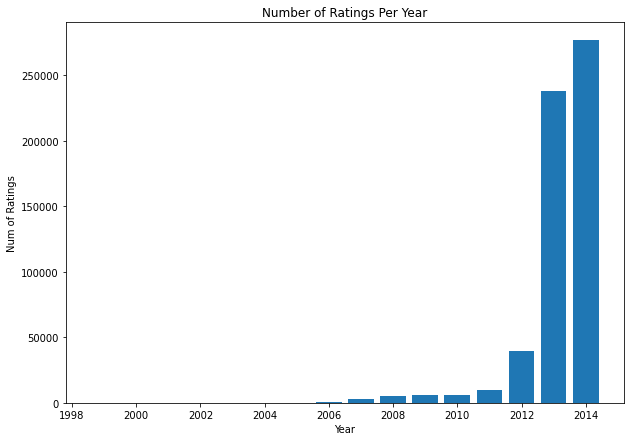

In [33]:
import matplotlib.pyplot as plt

#group by year and count num of ratings
pandas_video_ratings_by_year = pandas_video_ratings.groupby("year").count()[["rating"]]

fig, ax = plt.subplots()
ax.bar(pandas_video_ratings_by_year.index, pandas_video_ratings_by_year["rating"])

#customize appearance
fig.set_size_inches([10, 7])
ax.set_title("Number of Ratings Per Year")
ax.set_xlabel("Year")
ax.set_ylabel("Num of Ratings")
plt.show()

## Recommendation System

Now we'll build our ALS algorithm using collaborative filtering:

In [34]:
from pyspark.ml.recommendation import ALS

# Initialize ALS with parameters
als = ALS(userCol="reviewerID", 
          itemCol="videoID", 
          ratingCol="rating",
          nonnegative=True, 
          coldStartStrategy="drop", 
          implicitPrefs=False)

Next, we'll build the `ParamGridBuilder`:

In [35]:
from pyspark.ml.tuning import ParamGridBuilder

param_grid = ParamGridBuilder() \
                  .addGrid(als.rank, [5, 20]) \
                  .addGrid(als.maxIter, [5]) \
                  .addGrid(als.regParam, [0.01, 0.05, 1]) \
                  .build()

Now we'll build our evaluator and use RMSE as the performance metric:

In [36]:
from pyspark.ml.evaluation import RegressionEvaluator

# Define evaluator
reg_eval = RegressionEvaluator(metricName = "rmse",
                               predictionCol = "prediction",
                               labelCol = "rating")

print(f"Num models to be tested: {len(param_grid)}")

Num models to be tested: 6


Creating `CrossValidator`:

In [37]:
from pyspark.ml.tuning import CrossValidator

cv = CrossValidator(estimator = als, 
                    estimatorParamMaps= param_grid,
                    evaluator = reg_eval,
                    numFolds = 5)

Now, we can fit our training data:

*Note: the below cell may take over 35 minutes to execute if you aren't connected to a local runtime/GPU.*

In [38]:
# Split data into 80% train, 20% test
training_data, test_data = video_ratings.randomSplit([0.8, 0.2], seed = 0)

# Training model
model = cv.fit(training_data)

# Get best model
best_model = model.bestModel

In [39]:
print(type(best_model))

print("\n**Best Model**")
print("  Rank:", best_model.rank)
print("  MaxIter:", best_model._java_obj.parent().getMaxIter())
print("  RegParam:", best_model._java_obj.parent().getRegParam())

<class 'pyspark.ml.recommendation.ALSModel'>

**Best Model**
  Rank: 5
  MaxIter: 5
  RegParam: 1.0


Now we can evaluate our model's performance on the test data:

In [40]:
# Predict ratings using trained model
predictions = best_model.transform(test_data)
predictions.show(5)

+----------+-------+------+-------------------+----------+
|reviewerID|videoID|rating|          timestamp|prediction|
+----------+-------+------+-------------------+----------+
|       183|   8606|   5.0|2013-09-26 20:00:00| 3.8162308|
|       211|   2433|   5.0|2011-10-15 20:00:00|  2.509742|
|       362|   4016|   5.0|2013-08-04 20:00:00| 2.7433841|
|       362|  17397|   5.0|2014-01-07 19:00:00| 3.0645669|
|       744|   6003|   1.0|2014-04-27 20:00:00| 1.2805245|
+----------+-------+------+-------------------+----------+
only showing top 5 rows



In [41]:
# Evaluate the "test_predictions" dataframe
RMSE = reg_eval.evaluate(predictions)

# Print the RMSE
print(RMSE)

1.7310408906567112


### Generate Recommendations for Users

In [42]:
userRecs = best_model.recommendForAllUsers(5)
userRecs.show(5, truncate = False)

C:\Python\lib\site-packages\pyspark\sql\context.py:125: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


+----------+-------------------------------------------------------------------------------------------------+
|reviewerID|recommendations                                                                                  |
+----------+-------------------------------------------------------------------------------------------------+
|28        |[{5978, 4.7489047}, {8556, 4.679992}, {3934, 4.6203675}, {5625, 4.6137943}, {8774, 4.595674}]    |
|31        |[{5978, 4.716591}, {22993, 4.5564055}, {3934, 4.5079365}, {2930, 4.432905}, {14521, 4.4106317}]  |
|34        |[{5978, 4.839679}, {5625, 4.700465}, {12283, 4.681149}, {8882, 4.672271}, {8774, 4.580991}]      |
|53        |[{11046, 4.8518553}, {8614, 4.794093}, {3934, 4.613936}, {23951, 4.5901723}, {8556, 4.4638743}]  |
|78        |[{18886, 4.5035977}, {22993, 4.4489737}, {23300, 4.4354205}, {4501, 4.3111014}, {359, 4.2969604}]|
+----------+-------------------------------------------------------------------------------------------------+
o

In [43]:
userRecs_pandas = userRecs.toPandas()
userRecs_pandas.head()

,reviewerID,recommendations
0,28,"[(5978, 4.748904705047607), (8556, 4.679992198..."
1,31,"[(5978, 4.716590881347656), (22993, 4.55640554..."
2,34,"[(5978, 4.839678764343262), (5625, 4.700465202..."
3,53,"[(11046, 4.851855278015137), (8614, 4.79409313..."
4,78,"[(18886, 4.503597736358643), (22993, 4.4489736..."


In [44]:
def get_user_recommended_videos(recs_df, userId):
  try:
    recommendations = recs_df[recs_df["reviewerID"] == userId]["recommendations"]
    for video in recommendations[0]:
      print(f"VideoID: \n{video[0]}\nPredicted Rating: {video[1]}\n")
  except:
    print("That userId does not exist in the dataset.  Try another.")

In [45]:
get_user_recommended_videos(userRecs_pandas, 1)

That userId does not exist in the dataset.  Try another.


In [46]:
get_user_recommended_videos(userRecs_pandas, 28)

VideoID: 
5978
Predicted Rating: 4.748904705047607

VideoID: 
8556
Predicted Rating: 4.679992198944092

VideoID: 
3934
Predicted Rating: 4.620367527008057

VideoID: 
5625
Predicted Rating: 4.613794326782227

VideoID: 
8774
Predicted Rating: 4.59567403793335



## Conclusions